# Решение проекта Телеком

## Описание проекта

В данном проекте, нам предстоит помочь оператору связи «Ниединогоразрыва.ком», который хочет начать прогнозировать отток клиентов из своей сети. Для решения данной задачи оператор собрал базу данных, в которой содержатся:

- информация о договоре
- персональные данные клиента
- информация об интернет-услугах
- информация об услугах телефонии

Оператор связи предоставляет следующие виды услуг:

- основные:
    - Стационарную телефонную связь. Есть возможность подключаться к нескольким линиям одновременно
    - Интернет. Подключение возможно двух типов: 1) через телефонную линию (DSL) 2) оптоволоконный кабель (Fiber optic)
- дополнительные:
    - антивирус (Device Protection) и блокировка небезопасных сайтов (OnlineSecurity)
    - линия технической поддержки (TechSupport)
    - облачное хранилище (OnlineBackup)
    - стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies)

## Импорт библиотек

Перед началом работы нам стоит импортировать необходимые для решения библиотеки, ведь так намного удобнее, чем импортировать что-то нужное в середние проекта, а то и во все в конце. 

In [1]:
!pip install phik

import pandas as pd # создание таблиц и работа с ними
import numpy as np # работа с математическими задачами
from IPython.display import display # красивый вывод многих таблиц
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from phik import report
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 675 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 38.1 MB 63 kB/s s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow 2.1.0 requires scipy==1.4.1; python_version >= "3", but you'll have scipy 1.7.3 which is incompatible.


## Подготовка данных

### Загрузка данных и их просмотр

После импорта библиотек стоит заняться загрузкой данных в наш файл. Для этого воспользуемся локальным хранилищем Яндекса и сохраним все данные в переменные:

In [2]:
path = '/datasets/final_provider/' # общий путь 

contracts = pd.read_csv(path + 'contract.csv') # договора
personal_info = pd.read_csv(path + 'personal.csv') # персональная информация
internet_services = pd.read_csv(path + 'internet.csv') # услуги 
phones_info = pd.read_csv(path + 'phone.csv') # услуги телефонии

После загрузки данных в переменные можно начать их изучение. Просмотрим все значения в таблицах, а также краткую информацию по таблицам:

In [3]:
def show_data_info():
    datasets = [contracts, personal_info, internet_services, phones_info] # все таблицы
    titels = (['Информация о договорах', 'персональные данные клиента', 
               'информация об интернет-услугах', 'информация об услугах телефонии']) # Краткое описание таблицы
    for index, dataset in enumerate(datasets): # цикл по всем таблицам
        print('{:>70}'.format(titels[index]))
        display(dataset)
        dataset.info()
        print()

In [4]:
show_data_info()

                                                Информация о договорах


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

                                           персональные данные клиента


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

                                        информация об интернет-услугах


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB

                                       информация об услугах телефонии


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB



### Предобработка данных - меняем типы данных

После предварительного осмотра таблиц, можно отметить некоторые моменты:
- таблица contracts:
    - столбцы BeginDate и EndDate содержат object информацию, хотя должен являться типом date
    - столбец PaperlessBilling содержит данные типа object, но было бы удобнее хранить их в типе int64
    - TotalCharges содержит данные типа object, а должен быть типа float64
- personal_info:
    - столбцы Partner и Dependents содержат данные типа object, но было бы удобнее хранить их в типе int64
- internet_services:
    - столбцы OnlineSecurity, OnlineBackup,	DeviceProtection, TechSupport, StreamingTV,	StreamingMovies содержат данные типа object, но было бы удобнее хранить их в типе int64
- phones_info:
    - столбец MultipleLines содержит данные типа object, но было бы удобнее хранить их в типе int64

Так как у нас много столбцов, которые должны поменять object на int, то можем создать функцию, которая будет выполнять данный алгоритм:

In [5]:
def change_yes_no_col(data, col): # замена Yes, No на 1, 0
    return data[col].replace(['Yes', 'No'], [1, 0])

По ходу работы было замечено, что в столбце `TotalCharges` в таблице `contracts` присутствуют пропуски в виде пробела ' '. Поэтому мы заменяем данный пропуск на NaN значение. Также в столбце `EndDate` той же таблицы присутствуют значения `No`, которые также можно заменить на `NaN`:

In [6]:

contracts['TotalCharges'] = contracts['TotalCharges'].replace(' ', np.nan) # заменяем на NaN
contracts['EndDate'] = contracts['EndDate'].replace('No', '2020-02-01') # заменяем на актуальную информацию (заполнитель)

contracts['PaperlessBilling'] = change_yes_no_col(contracts, 'PaperlessBilling') # вызов функции change_yes_no_col

contracts['BeginDate'] = pd.to_datetime(contracts['BeginDate'], format='%Y-%m-%d') # перевод типа в date
contracts['EndDate'] = pd.to_datetime(contracts['EndDate'], format='%Y-%m-%d')

contracts['TotalCharges'] = contracts['TotalCharges'].astype('float64') # перевод типа во float
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null int64
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 440.3+ KB


In [7]:
personal_info['Partner'] = change_yes_no_col(personal_info, 'Partner') # вызов функции change_yes_no_col
personal_info['Dependents'] = change_yes_no_col(personal_info, 'Dependents') # вызов функции change_yes_no_col
personal_info.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,1,0
1,5575-GNVDE,Male,0,0,0
2,3668-QPYBK,Male,0,0,0
3,7795-CFOCW,Male,0,0,0
4,9237-HQITU,Female,0,0,0


In [8]:
columns_internet_ser = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in columns_internet_ser:
    internet_services[col] = change_yes_no_col(internet_services, col) # вызов функции change_yes_no_col
internet_services.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0
3,7795-CFOCW,DSL,1,0,1,1,0,0
4,9237-HQITU,Fiber optic,0,0,0,0,0,0


In [9]:
phones_info['MultipleLines'] = change_yes_no_col(phones_info, 'MultipleLines') # вызов функции change_yes_no_col
phones_info.head()

,customerID,MultipleLines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1


In [10]:
show_data_info()

                                                Информация о договорах


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,1,Mailed check,84.80,1990.50
7039,2234-XADUH,2014-02-01,2020-02-01,One year,1,Credit card (automatic),103.20,7362.90
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,1,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,1,Mailed check,74.40,306.60


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null int64
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 440.3+ KB

                                           персональные данные клиента


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,1,0
1,5575-GNVDE,Male,0,0,0
2,3668-QPYBK,Male,0,0,0
3,7795-CFOCW,Male,0,0,0
4,9237-HQITU,Female,0,0,0
...,...,...,...,...,...
7038,6840-RESVB,Male,0,1,1
7039,2234-XADUH,Female,0,1,1
7040,4801-JZAZL,Female,0,1,1
7041,8361-LTMKD,Male,1,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null int64
Dependents       7043 non-null int64
dtypes: int64(3), object(2)
memory usage: 275.2+ KB

                                        информация об интернет-услугах


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0
3,7795-CFOCW,DSL,1,0,1,1,0,0
4,9237-HQITU,Fiber optic,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,1,0,1,1,1,1
5513,2234-XADUH,Fiber optic,0,1,1,0,1,1
5514,4801-JZAZL,DSL,1,0,0,0,0,0
5515,8361-LTMKD,Fiber optic,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null int64
OnlineBackup        5517 non-null int64
DeviceProtection    5517 non-null int64
TechSupport         5517 non-null int64
StreamingTV         5517 non-null int64
StreamingMovies     5517 non-null int64
dtypes: int64(6), object(2)
memory usage: 344.9+ KB

                                       информация об услугах телефонии


,customerID,MultipleLines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1
...,...,...
6356,2569-WGERO,0
6357,6840-RESVB,1
6358,2234-XADUH,1
6359,8361-LTMKD,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null int64
dtypes: int64(1), object(1)
memory usage: 99.5+ KB



### Предобработка данных - повторяющиеся значения

Замену типов данных мы выполнили, но у нас остались еще некоторые проверки:
- повторяющиеся значения
- пропуски в данных
- аномалии в данных

Давайте займемся проверкой на повторение данных. Для этого мы воспользуемся столбцом customerID:

In [11]:
def count_uniq(data):
    return data['customerID'].value_counts().sort_values(ascending=False).head()

In [12]:
count_uniq(contracts)

3807-BPOMJ    1
7603-USHJS    1
5955-ERIHD    1
4742-DRORA    1
5732-IKGQH    1
Name: customerID, dtype: int64

In [13]:
count_uniq(personal_info)

3807-BPOMJ    1
7603-USHJS    1
5955-ERIHD    1
4742-DRORA    1
5732-IKGQH    1
Name: customerID, dtype: int64

In [14]:
count_uniq(internet_services)

5119-NZPTV    1
4377-VDHYI    1
8617-ENBDS    1
9060-HJJRW    1
4075-JFPGR    1
Name: customerID, dtype: int64

In [15]:
count_uniq(phones_info)

3807-BPOMJ    1
1240-KNSEZ    1
2737-YNGYW    1
1336-EZFZY    1
5955-ERIHD    1
Name: customerID, dtype: int64

Как мы видим, у наших столбцов нет никаких повторяющихся значений, а значит мы можем перейти к другому вопросу - аномалии в данных.

### Предобработка данных - аномалии в данных

Для этого проверим данные через команду `describe`, которая покажет нам максимальные, минимальные, средние и медианы. Однако проверять мы будем лишь одну таблицу, ведь в оставшихся просто нету столбцов, которые нужно изучать:

In [16]:
contracts.describe()

,PaperlessBilling,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,0.592219,64.761692,2283.300441
std,0.491457,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,0.000000,35.500000,401.450000
50%,1.000000,70.350000,1397.475000
75%,1.000000,89.850000,3794.737500
max,1.000000,118.750000,8684.800000


Просмотрев на максимальные значения можно подумать, что все нормальное, значения в пределе допустимого, но все таки, давайте проверим. Проверять будем следующим образом: найдем людей, которые платят такие цифры, проверим услуги, которыми они пользуются. Первым будет проверка месячной траты на 118.75

In [17]:
contracts[contracts['MonthlyCharges'] == 118.75]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4586,7569-NMZYQ,2014-02-01,2020-02-01,Two year,1,Bank transfer (automatic),118.75,8672.45


Пользователь с ID 7569-NMZYQ, давайте проверим его услуги:

In [18]:
internet_services[internet_services['customerID'] == '7569-NMZYQ']

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3581,7569-NMZYQ,Fiber optic,1,1,1,1,1,1


Услуги в норме, он платит за все + платит за оптоволокно, что должно быть дороже. Давайте теперь проверим самые высокие годовые затраты:

In [19]:
contracts[contracts['TotalCharges'] == 8684.8]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4610,2889-FPWRM,2013-10-01,2019-10-01,One year,1,Bank transfer (automatic),117.8,8684.8


Пользователь 2889-FPWRM тратит больще всех в год. Давайте узнаем, правда ли он так много тратит:

In [20]:
internet_services[internet_services['customerID'] == '2889-FPWRM']

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3599,2889-FPWRM,Fiber optic,1,1,1,1,1,1


Как видно, да, он покупает все услуги и пользуется оптоволокном. Чтож, аномалий также не найдено, теперь можно перейти к пропускам в данных

### Предобработка данных - пропуски (создаем единую таблицу)

В данных присутствует довольно много пропусков, а именно в столбце `EndDate` таблицы `contracts`. Удалять такие данные нельзя, ведь это может привести к ухудшению прогноза будущей модели. Подставлять значения также неразумно, ведь дата окончания пользования услугами оператора значение важное, его нельзя придумать и подставить. Следуя из всего сказанного, мы не будем их удалять, но используем для составления целевого значения.

Но у нас есть 11 пустых значений в столбце `TotalCharges`, их можно будет удалить:

In [21]:
contracts = contracts[contracts['TotalCharges'].isna() == False]

In [22]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7032 non-null object
BeginDate           7032 non-null datetime64[ns]
EndDate             7032 non-null datetime64[ns]
Type                7032 non-null object
PaperlessBilling    7032 non-null int64
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 494.4+ KB


Теперь данные таблицы `contracts` приведены в готовый для объединения вид с остальными таблицами. Однако стоит отметить, что в наших таблицах присутствует различие в размере таблиц: 7032 в таблице `contracts`, 5512 в таблице `internet_services`, а также 6352 в `phones_info`. Почему у нас присутствует такое различие в данных? Потому что в таблице есть пользователи, которые либо не пользуются интернетом, либо не пользуются стационарной телефонной связью. Удалять такие строки мы не можем, ведь это важные для анализа данные, но дополнить их мы сможем: 

In [23]:
total_data = pd.merge(contracts, personal_info, on="customerID", how='left')
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 12 columns):
customerID          7032 non-null object
BeginDate           7032 non-null datetime64[ns]
EndDate             7032 non-null datetime64[ns]
Type                7032 non-null object
PaperlessBilling    7032 non-null int64
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null int64
Dependents          7032 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(4), object(4)
memory usage: 714.2+ KB


In [24]:
total_data = pd.merge(total_data, internet_services, on="customerID", how='left')
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 19 columns):
customerID          7032 non-null object
BeginDate           7032 non-null datetime64[ns]
EndDate             7032 non-null datetime64[ns]
Type                7032 non-null object
PaperlessBilling    7032 non-null int64
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null int64
Dependents          7032 non-null int64
InternetService     5512 non-null object
OnlineSecurity      5512 non-null float64
OnlineBackup        5512 non-null float64
DeviceProtection    5512 non-null float64
TechSupport         5512 non-null float64
StreamingTV         5512 non-null float64
StreamingMovies     5512 non-null float64
dtypes: datetime64[ns](2), float64(8), int64(4), object(5)
memory usage: 1.1+ MB


In [25]:
total_data = pd.merge(total_data, phones_info, on="customerID", how='left')
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
customerID          7032 non-null object
BeginDate           7032 non-null datetime64[ns]
EndDate             7032 non-null datetime64[ns]
Type                7032 non-null object
PaperlessBilling    7032 non-null int64
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null int64
Dependents          7032 non-null int64
InternetService     5512 non-null object
OnlineSecurity      5512 non-null float64
OnlineBackup        5512 non-null float64
DeviceProtection    5512 non-null float64
TechSupport         5512 non-null float64
StreamingTV         5512 non-null float64
StreamingMovies     5512 non-null float64
MultipleLines       6352 non-null float64
dtypes: datetime64[ns](2), float64(9), int64(4), obj

Давайте посмотрим, какие значения есть в столбце `MultipleLines`, когда в столбце `InternetService` пропуски:

In [26]:
total_data[total_data['InternetService'].isna() == True]['MultipleLines'].value_counts()

0.0    1180
1.0     340
Name: MultipleLines, dtype: int64

Как видно, 1520 пропусков в столбце `InternetService` полностью заполнены в столбце `MultipleLines`: 1180 людей пользуются стационарной телефонной связью, но не используют дополнительную услугу ведения параллельных линий во время звонка, в то время как 340 людей используют дополнительную услугу. 

Теперь нужно убедиться в том, что пропуски в столбце `MultipleLines` никак не влияют на значения в столбце `InternetService`:

In [27]:
total_data[total_data['MultipleLines'].isna() == True]['InternetService'].value_counts()

DSL    680
Name: InternetService, dtype: int64

Как мы знаем по выводам выше, в столбце `MultipleLines` присутствует 680 пропусков, но в тех же строках в столбце `InternetService` есть одно постоянное значение - `DSL`. Это значит, что люди не пользуются стационарной телефонной связью, но используют интернет, а именно тип подключения `DSL`. 

Таблицы объединены в одну общую - `total_data`. Давайте поработаем с ней.

In [28]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
customerID          7032 non-null object
BeginDate           7032 non-null datetime64[ns]
EndDate             7032 non-null datetime64[ns]
Type                7032 non-null object
PaperlessBilling    7032 non-null int64
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null int64
Dependents          7032 non-null int64
InternetService     5512 non-null object
OnlineSecurity      5512 non-null float64
OnlineBackup        5512 non-null float64
DeviceProtection    5512 non-null float64
TechSupport         5512 non-null float64
StreamingTV         5512 non-null float64
StreamingMovies     5512 non-null float64
MultipleLines       6352 non-null float64
dtypes: datetime64[ns](2), float64(9), int64(4), obj

Первое, что необходимо "почистить" - пустые значения, но мы не будем их удалять. Мы создадим дополнительные столбцы, которые составят новые значения, относительно тех столбцов, что пустуют. Для начала мы поработаем со столбцом `InternetService`. В данном столбце мы имеем `1520` пустых значений, а это значит, что мы знаем, сколько клиентов используют интернет - 5512 клиентов, остальные не имеют данную услугу на своем аккаунте - отсюда появляется столбец `Internet`. Также по такому принципу появляется столбец `LandlinePhone` - использует ли пользователь услугу станционарного телефона.

Далее мы используем столбцы `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies` и ранее созданный `Internet`. Если пользователь использует интернет, то мы можем подсчитать сколько дополнительных услуг он приобрел - это новый столбец `AmountInternetServices`.

Столбец `InternetService` также нам понадобится в будущем, поэтому его пустые значения мы заполним заполнителем - `Nothing`.   

In [29]:
def use_internet_or_not(internet_servi):
    if internet_servi == 'Nothing':
        return 0
    else:
        return 1

def use_landline_phone_or_not(landline_phone):
    if landline_phone == -1:
        return 0
    else:
        return 1
    
def count_internet_services(data):
    if data['Internet'] == 1:
        return int(data[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies']].sum())
    else:
        return 0

In [30]:
total_data['InternetService'] = total_data['InternetService'].fillna('Nothing')
total_data['MultipleLines'] = total_data['MultipleLines'].fillna(-1)

total_data['Internet'] = total_data['InternetService'].apply(use_internet_or_not)
total_data['LandlinePhone'] = total_data['MultipleLines'].apply(use_landline_phone_or_not)

total_data['AmountInternetServices'] = total_data.apply(count_internet_services, axis=1)


total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 23 columns):
customerID                7032 non-null object
BeginDate                 7032 non-null datetime64[ns]
EndDate                   7032 non-null datetime64[ns]
Type                      7032 non-null object
PaperlessBilling          7032 non-null int64
PaymentMethod             7032 non-null object
MonthlyCharges            7032 non-null float64
TotalCharges              7032 non-null float64
gender                    7032 non-null object
SeniorCitizen             7032 non-null int64
Partner                   7032 non-null int64
Dependents                7032 non-null int64
InternetService           7032 non-null object
OnlineSecurity            5512 non-null float64
OnlineBackup              5512 non-null float64
DeviceProtection          5512 non-null float64
TechSupport               5512 non-null float64
StreamingTV               5512 non-null float64
StreamingMovies           55

## Создание целевой переменной и подготовка таблицы к анализу

### Создание целевой переменной

Отлично, мы создали два новых, важных столбца и дополнили уже существующий новыми значениями. Теперь нам нужно рассмотреть столбец `EndDate`, от которого зависит продолжает ли клиент использовать услуги оператора связи или нет. Пустые строки в данном столбце заполнять не нужно, ведь это и есть наша целевая переменная: если дата указана, то клиент завершил пользование услугами, в противном случае клиент продолжает быть пользователем оператора связи. Однако с такой датой работать неудобно, да и позже нам понадобится столбец, который укажет на продолжительность использования услугами оператора связи, чтобы предложить пользователю какие-нибудь скидки или услуги. Следовательно нам нужен новый столбец - `DaysContract` - он укажет на то, сколько дней клиент использует услуги оператора связи. 

In [31]:
total_data['DaysContract'] = (total_data['EndDate']-total_data['BeginDate']).dt.days
total_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Internet,LandlinePhone,AmountInternetServices,DaysContract
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,Female,0,...,1.0,0.0,0.0,0.0,0.0,-1.0,1,0,1,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,Male,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,1,2,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,Male,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1,1,2,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,Male,0,...,0.0,1.0,1.0,0.0,0.0,-1.0,1,0,2,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,Female,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,61


Пропуск в столбце `DaysContract` указывает нам на тот факт, что клиент все еще является пользователем услуг, а значит на базе данного столбца мы можем построить целевой признак - `ActiveClient`, где значение 0 указывает на то, что клиент перестал использовать услуги оператора связи, а 1 наоборот - клиент все еще пользуется услугами:

In [32]:
def active_client_or_not(row):
    value = row['EndDate'].strftime('%Y-%m-%d')
    if value == '2020-02-01':
        return 0
    else:
        return 1
    
total_data['ActiveClient'] = total_data.apply(active_client_or_not, axis=1)
total_data.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Internet,LandlinePhone,AmountInternetServices,DaysContract,ActiveClient
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,Female,0,...,0.0,0.0,0.0,0.0,-1.0,1,0,1,31,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,Male,0,...,1.0,0.0,0.0,0.0,0.0,1,1,2,1036,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,Male,0,...,0.0,0.0,0.0,0.0,0.0,1,1,2,61,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,Male,0,...,1.0,1.0,0.0,0.0,-1.0,1,0,2,1371,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,Female,0,...,0.0,0.0,0.0,0.0,0.0,1,1,0,61,1


### Подготовка таблицы к анализу

Все столбцы составлены и подготовлены, а это означает, что теперь можно убирать неважные для построения модели признаки: 
- столбец `customerID` не несет никакую информацию, поэтому его можно смело удалить;
- столбцы `BeginDate` и `EndDate` хоть и несут важную информацию, но с их помощью мы реализовали другие столбцы, которые нам и помогут в предсказании оттока клиентов;
- столбцы `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies` позволили создать один столбец, который показывает, сколько дополнительных услуг использует пользователь, поэтому данные столбцы нам также не понадобятся;
- столбец `gender` аналогично столбцу `customerID` не несет важной информации, ведь использование услугами оператора связи не должно зависит от вашего пола.

In [33]:
ready_data = total_data.drop(['customerID', 'BeginDate', 'EndDate', 'gender', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'], axis=1)
#ready_data = total_data.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)
ready_data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,MultipleLines,Internet,LandlinePhone,AmountInternetServices,DaysContract,ActiveClient
0,Month-to-month,1,Electronic check,29.85,29.85,0,1,0,DSL,-1.0,1,0,1,31,0
1,One year,0,Mailed check,56.95,1889.50,0,0,0,DSL,0.0,1,1,2,1036,0
2,Month-to-month,1,Mailed check,53.85,108.15,0,0,0,DSL,0.0,1,1,2,61,1
3,One year,0,Bank transfer (automatic),42.30,1840.75,0,0,0,DSL,-1.0,1,0,2,1371,0
4,Month-to-month,1,Electronic check,70.70,151.65,0,0,0,Fiber optic,0.0,1,1,0,61,1


Остались лишь необходимые столбцы, а это значит, что пора приводит текстово-категорийные признаки в число-категорийный вид. Признаками, которые мы будем переводить в число-категорийный вид будут: `Type`, `PaymentMethod` и `InternetService`. Но перед тем, как переводить их в другой вид, давайте посмотрим на значения категорий:

In [34]:
ready_data['Type'].value_counts()

Month-to-month    3875
Two year          1685
One year          1472
Name: Type, dtype: int64

Как можно заметить, пользователи больше всего подписывают договор на помесячную оплату и только потом на два либо один год.

In [35]:
ready_data['InternetService'].value_counts()

Fiber optic    3096
DSL            2416
Nothing        1520
Name: InternetService, dtype: int64

Логично, что больше всего пользователей захотят использовать оптоволокно, ведь так скорость выше и устойчивей соединение. После оптоволокна подключают DSL соединение и оставшиеся 1520 пользователей вообще не используют интернет данного оператора.

In [36]:
ready_data['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64

Как можно заметить, пользователи любят оплачивать через электронный чек, потом идет чек через почту, автоматическая оплата через банк, на равне с которой идет оплата через карту. 

In [37]:
encoder = LabelEncoder()
cat_col = ['Type', 'PaymentMethod', 'InternetService']

ready_data[cat_col] = ready_data[cat_col].apply(encoder.fit_transform)
ready_data.head(10)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,MultipleLines,Internet,LandlinePhone,AmountInternetServices,DaysContract,ActiveClient
0,0,1,2,29.85,29.85,0,1,0,0,-1.0,1,0,1,31,0
1,1,0,3,56.95,1889.50,0,0,0,0,0.0,1,1,2,1036,0
2,0,1,3,53.85,108.15,0,0,0,0,0.0,1,1,2,61,1
3,1,0,0,42.30,1840.75,0,0,0,0,-1.0,1,0,2,1371,0
4,0,1,2,70.70,151.65,0,0,0,1,0.0,1,1,0,61,1
5,0,1,2,99.65,820.50,0,0,0,1,1.0,1,1,3,245,1
6,0,1,1,89.10,1949.40,0,0,1,1,1.0,1,1,2,671,0
7,0,0,3,29.75,301.90,0,0,0,0,-1.0,1,0,1,306,0
8,0,1,2,104.80,3046.05,0,1,0,1,1.0,1,1,3,853,1
9,1,0,0,56.15,3487.95,0,0,1,0,0.0,1,1,2,1888,0


In [38]:
ready_data['LandlinePhone'].value_counts()

1    6352
0     680
Name: LandlinePhone, dtype: int64

Столбец `Type` изменил свои значения на:
- Month-to-month - 0
- Two year - 2
- One year - 1

Столбец `PaymentMethod` изменил значения на:
- Electronic check - 2
- Mailed check - 3
- Bank transfer (automatic) - 0
- Credit card (automatic) - 1

Столбец `InternetService` поменял значения на:
- Fiber optic - 1
- DSL - 0
- Nothing - 2 

## Исследовательский анализ

### Зависимость признака к признаку

Давайте теперь посмотрим на зависимость признаков друг от друга с помощью графиков:

Text(0.5, 1.0, 'Общий доход от вида договора')

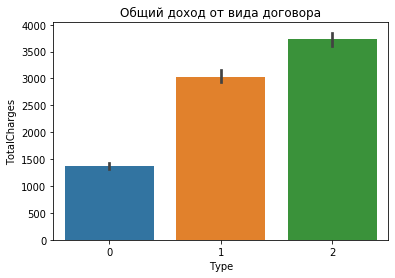

In [39]:
sns.barplot(x='Type', y='TotalCharges', data=ready_data)
plt.title('Общий доход от вида договора')

Самый большой суммарный доход оператор связи получает с договоров подписанных на два года, потом с подпиской на год и последний на месячную подписку. Почему такие результаты? Потому что один годовой контракт = 12 контрактам на месяц, а с двух годовой подпиской цифры еще выше. Такой вид дохода по графику общего дохода хорош, но если сравнить доходы помесячный, то картина станет немного другой:

Text(0.5, 1.0, 'Помесячный доход от вида договора')

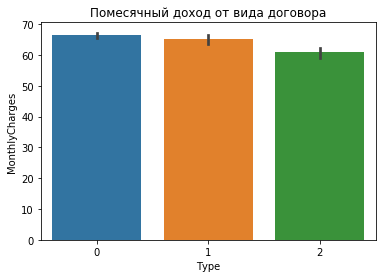

In [40]:
sns.barplot(x='Type', y='MonthlyCharges', data=ready_data)
plt.title('Помесячный доход от вида договора')

Если весь доход с договоров разбить на месячный, то получится, что месячные контракты выходят немного выгоднее длительных годовых и двухгодовых. 

Text(0.5, 1.0, 'Разница доходов в месяц от типа интернет подключения')

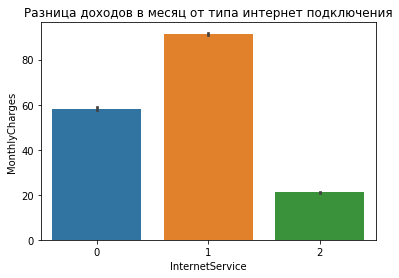

In [41]:
sns.barplot(x='InternetService', y='MonthlyCharges', data=ready_data)
plt.title('Разница доходов в месяц от типа интернет подключения')

Логично было предположить, что подключенные к оптоволокну клиенты принесут больше дохода в компанию, ведь интернет при таком подключении гораздо быстрее и устойчивей.

Text(0.5, 1.0, 'Зависимость общего дохода от количества интернет услуг')

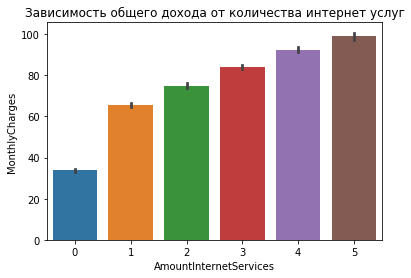

In [42]:
sns.barplot(x='AmountInternetServices', y='MonthlyCharges', data=ready_data)
plt.title('Зависимость общего дохода от количества интернет услуг')

На данном графике картина предсказуемая - чем больше пользователь берет услуг, тем больше он платит и компания получает больше дохода. 

Text(0.5, 1.0, 'Зависимость общего дохода от использовании услуг телефонии')

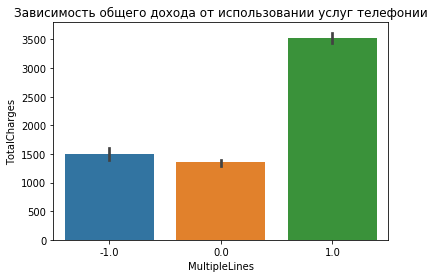

In [43]:
sns.barplot(x='MultipleLines', y='TotalCharges', data=ready_data)
plt.title('Зависимость общего дохода от использовании услуг телефонии')

Здесь можно заметить, что пользователи, которые подключают параллельные линии для станционарного телефона, тратят довольно много денег, но нашему оператору это как раз на руку.

### Длительность контрактов с пользователями

Для работы с длительностью контрактов нам понадобится выборка данных, в которой контракты тех пользователей, что закончили пользоваться услугами оператора. Поэтому мы создадим переменную `contract_ended`

In [44]:
contract_ended = ready_data[ready_data['DaysContract'] > 0]['DaysContract']

Text(0.5, 1.0, 'Количество контрактов по продолжительности пользования')

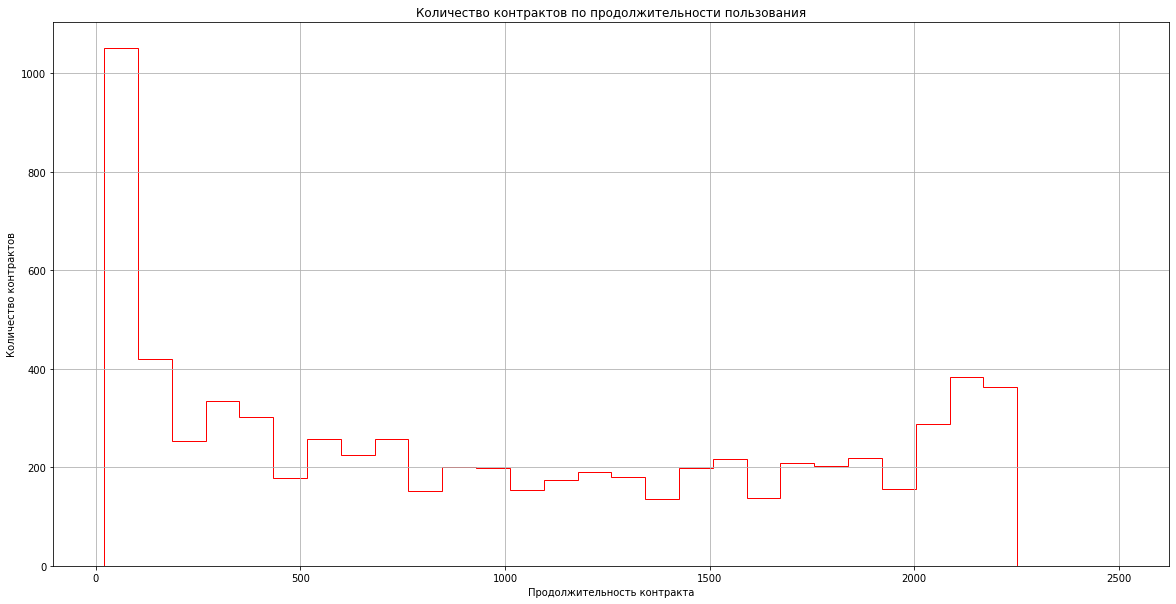

In [45]:
contract_ended.hist(bins=30, range=(20, 2500), histtype='step', color='red', figsize=(20,10))
plt.xlabel('Продолжительность контракта')
plt.ylabel('Количество контрактов')
plt.title('Количество контрактов по продолжительности пользования')

Последний график показывает нам, через сколько дней клиенты покидают оператора услуг. Как можно заметить, чаще всего клиенты покидают компанию спустя 10-100 дней, то есть в первые три месяца, если клиенту что-то не понравилось, он может уйти к другому оператору.

Text(0.5, 1.0, 'Длительность контракта и его значения')

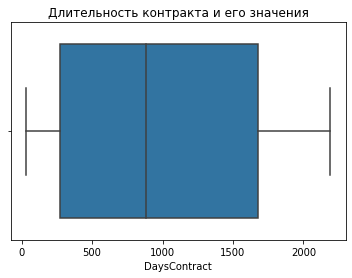

In [46]:
sns.boxplot(x=contract_ended)
plt.title('Длительность контракта и его значения')

По графику ящик усов видно, что медианное значение находится в промежутке 800-900 дней, сильный сдвиг третьего квантиля и максимального значения

In [47]:
contract_ended.describe()

count    7032.000000
mean      987.538538
std       747.153663
min        30.000000
25%       275.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: DaysContract, dtype: float64

По таблице выше, можно заметить, что медианное значение равно 883 (почти также, как мы отметили у ящика усов), квантили 1 и 3 равны 275 и 1676 соответственно.

Исходя из выше сказанного, можно отметить следующие моменты:
- много людей разрывают контракт с компанией на 60-100 день
- после промежутка в 120 дней динамика ухода с компании падает, но с 2000 дня опать идет повышения возможности ухода
- необходимо обратить внимание на значения 50 и 800


### Анализ дней разрыва контракта

Узнав, что диапазон разрыва контракта, в начале, равен 60-100 дню, а медианное значение ухода от оператора равна 883, можно проанализировать три диапазона: до 50 дня, с 50 до 800 и после 800 дня:

In [48]:
ready_data[(ready_data['DaysContract'] > 0) & (ready_data['DaysContract'] <= 50)]['AmountInternetServices'].value_counts()

0    403
1    147
2     50
3     12
4      1
Name: AmountInternetServices, dtype: int64

Как можно заметить, в первые 50 дней люди используют либо одну дополнительную услугу, либо вообще ничего. Отсюда можно сделать вывод - клиенту, который захочет уйти от оператора в данный промежуток времени, можно предложить дополнительную услугу бесплатно на весь срок пользования услугами оператора. 

In [49]:
ready_data[(ready_data['DaysContract'] > 50) & (ready_data['DaysContract'] <= 800)]['AmountInternetServices'].value_counts()

0    1062
1     675
2     541
3     342
4     111
5      13
Name: AmountInternetServices, dtype: int64

In [50]:
ready_data[(ready_data['DaysContract'] > 50) & (ready_data['DaysContract'] <= 800)]['MonthlyCharges'].describe()

count    2744.000000
mean       59.721501
std        27.640207
min        18.700000
25%        29.800000
50%        64.900000
75%        83.200000
max       112.950000
Name: MonthlyCharges, dtype: float64

Второй промежуток от 50 до 800 показывает нам следующую картину:
- пользователи используют либо одну дополнительную услугу, либо опять же ничего
- больще пользователей используют 0, 1 или 2 дополнительные услуги
- по затратам в месяц пользователи тратят больше всего в промежутке 59-83 денежных значений (не знаю, доллары или нет). 

Исходя из полученных данных можно предложить оператору:
- если пользователь тратит меньше 59 денежных значений и использует от 0-1 дополнительных услуг, то предлагаем бесплатную дополнительную услугу на время пользования услугами оператора
- если пользователь тратит больше 59 денежных значений  и/или использует от 2-4 дополнительных услуг, то предлагаем 25% скидку на месячную оплату всех услуг оператора, бессрочно

In [52]:
ready_data[ready_data['DaysContract'] > 800]['AmountInternetServices'].value_counts()

0    850
3    802
4    741
2    613
5    362
1    307
Name: AmountInternetServices, dtype: int64

In [53]:
ready_data[(ready_data['DaysContract'] > 800)]['MonthlyCharges'].describe()

count    3675.000000
mean       70.976163
std        31.120699
min        18.250000
25%        46.325000
50%        79.350000
75%        97.750000
max       118.750000
Name: MonthlyCharges, dtype: float64

Последний промежуток - от 300 дней и до конца. Здесь пользователи используют 0 или 3 услуги, чутка меньше с 4 или 2 услугами, остальные либо вообще не используют, либо используют все, что есть. Затраты также стали выше - больше всего тратят с 70 до 97 денежных значений.

По тем выводам, которые мы сделали в прошлом параграфе, можно предложить оператору следующее:
- Если пользователь тратит меньше 70 денежных значений, то ему предлагается скидка 25% либо дополнительная услуга бесплатно
- В остальных случаях предлагается скидка 50%

### Корреляция к целевой переменной

Теперь можно сосредоточиться на завсимости признаков к нашей целевой переменной - `ActiveClient`. Для того, чтобы как-то понять от каких признаков зависит активность пользователя предлагается построить корреляцию Пирсона, диаграмму размаха и корреляционную матрицу: 

In [53]:
ready_data.corr()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,MultipleLines,Internet,LandlinePhone,AmountInternetServices,DaysContract,ActiveClient
Type,1.000000,-0.175475,-0.229636,-0.072739,0.450306,-0.141820,0.294094,0.240556,0.099579,0.084037,-0.241574,0.003019,0.246469,0.676787,-0.396150
PaperlessBilling,-0.175475,1.000000,-0.061348,0.351930,0.157830,0.156258,-0.013957,-0.110131,-0.138166,0.133538,0.320592,0.016696,0.200776,0.004729,0.191454
PaymentMethod,-0.229636,-0.061348,1.000000,-0.192500,-0.330594,-0.038158,-0.156232,-0.041989,0.084504,-0.134147,-0.125799,-0.005499,-0.239682,-0.370053,0.107852
MonthlyCharges,-0.072739,0.351930,-0.192500,1.000000,0.651065,0.219874,0.097825,-0.112343,-0.322173,0.491412,0.763191,0.248033,0.743122,0.246715,0.192858
TotalCharges,0.450306,0.157830,-0.330594,0.651065,1.000000,0.102411,0.319072,0.064653,-0.175691,0.412495,0.374878,0.113008,0.740919,0.825811,-0.199484
SeniorCitizen,-0.141820,0.156258,-0.038158,0.219874,0.102411,1.000000,0.016957,-0.210550,-0.032160,0.113769,0.182519,0.008392,0.095444,0.015630,0.150541
Partner,0.294094,-0.013957,-0.156232,0.097825,0.319072,0.016957,1.000000,0.452269,0.000513,0.118037,0.000286,0.018397,0.202715,0.381924,-0.149982
Dependents,0.240556,-0.110131,-0.041989,-0.112343,0.064653,-0.210550,0.452269,1.000000,0.044030,-0.019178,-0.138383,-0.001078,0.017329,0.163442,-0.163128
InternetService,0.099579,-0.138166,0.084504,-0.322173,-0.175691,-0.032160,0.000513,0.044030,1.000000,0.186852,-0.803074,0.387266,-0.445804,-0.029809,-0.047097
MultipleLines,0.084037,0.133538,-0.134147,0.491412,0.412495,0.113769,0.118037,-0.019178,0.186852,1.000000,0.082989,0.674824,0.198907,0.259028,0.036148


По таблице можно сказать, что неплохую корреляцию к признаку `ActiveClient` имеют: `Type`, `PaperlessBilling`, `MonthlyCharges`, `TotalCharges`, `Dependents`, `Internet`, `Partner`, `SeniorCitizen`. Давайте проверим их, но уже на диаграмме размаха:

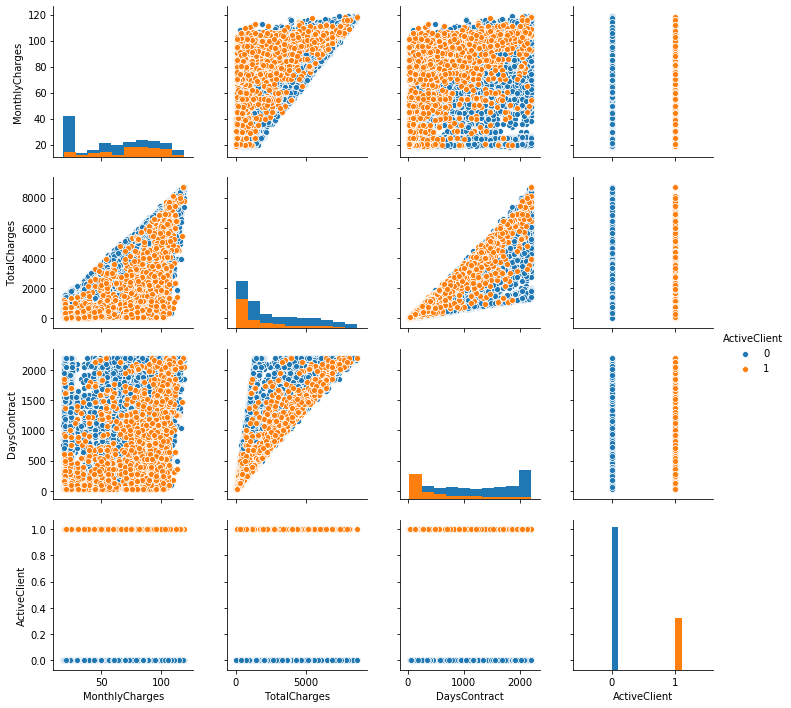

In [54]:
pirs_corr_col = ['MonthlyCharges', 'TotalCharges', 'DaysContract','ActiveClient']
sns.pairplot(ready_data[pirs_corr_col], hue="ActiveClient", diag_kind="hist")

Диаграмма размаха показала нам, что все количественные переменные одинаковы как у тех, кто все еще пользуется услугами оператора связи и у тех, кто уже прекратил использовать услуги. Пора нам перейти к другому методу - корреляционной матрице в виде графика:

In [55]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'DaysContract']
phik_overview = ready_data.phik_matrix(interval_cols=interval_cols)

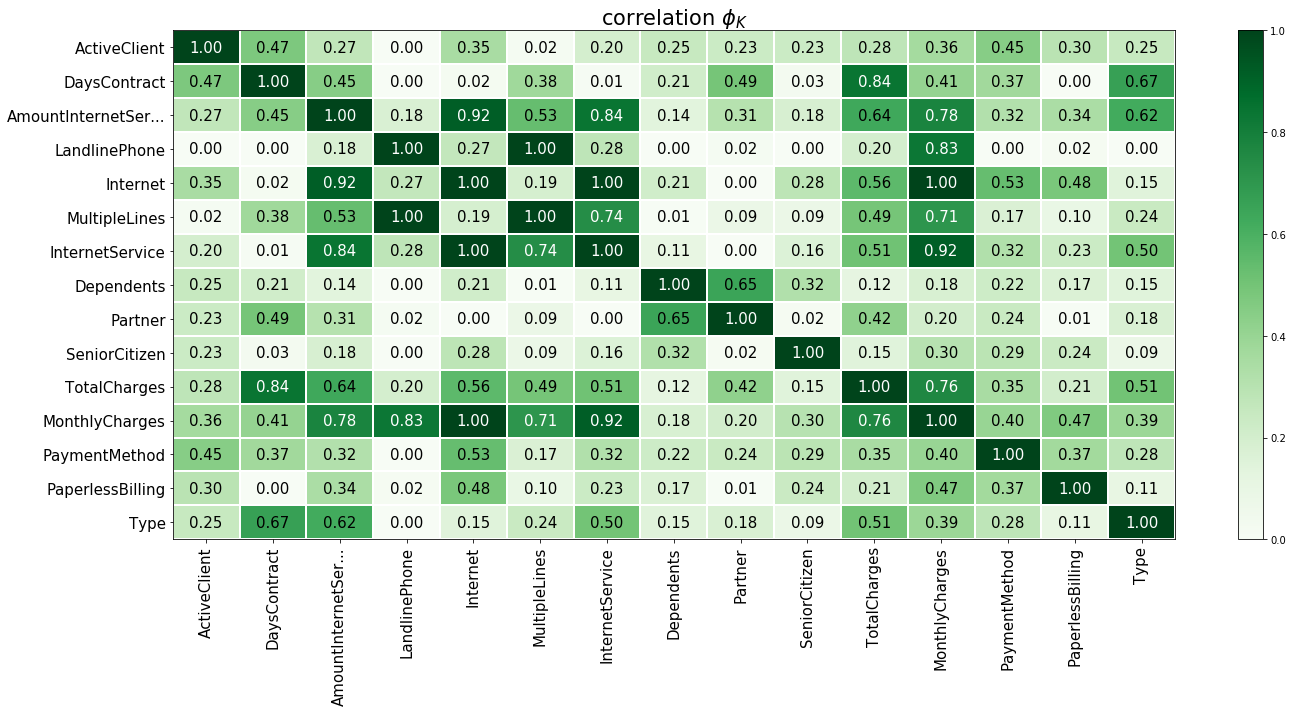

In [56]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()

По такому графику сразу видно, какие признаки лучше всего использовать: `DaysContract`, `PaymentMethod`, `MonthlyCharges`, `TotalCharges`, `Internet`, `PaperlessBilling`, `AmountInternetServices`, `Type`, `Dependents`. Однако стоит заметить, что у нас есть два признака, которые напрямую зависят друг от друга: `MonthlyCharges` и `TotalCharges`. Необходимо убрать один из них, и предлагается убрать `TotalCharges`, ведь он полностью строится из тех данных, что поступают от `MonthlyCharges`

In [55]:
most_corr_col = ['DaysContract', 'PaymentMethod', 'MonthlyCharges', 'Internet', 'PaperlessBilling', 'AmountInternetServices', 'Type', 'Dependents']

## Обучение

### Подготовка выборок

Пора формировать обучающую и тестовую выборки. Признаки мы выбрали, целевая переменная у нас есть. Разделение выборок можно сделать 75/25:

In [56]:
train_features, test_features, train_target, test_target = train_test_split(ready_data[most_corr_col], 
                                                                            ready_data['ActiveClient'], 
                                                                            test_size=0.25, random_state=96)
print(train_features.shape, test_features.shape)

(5274, 8) (1758, 8)


Данные поделены на обучающую и тестовую выборки. Но давайте вспомним, что у нас есть численные признаки, которые можно масштабировать: `MonthlyCharges` и `DaysContract`. Давайте проведем масштабирование признаков с помощью `StandardScaler`:

In [57]:
numeric = ['MonthlyCharges', 'DaysContract']

scaler = StandardScaler()
scaler.fit(train_features[numeric])

train_features[numeric] = scaler.transform(train_features[numeric])
test_features[numeric] = scaler.transform(test_features[numeric])

train_features.head()

,DaysContract,PaymentMethod,MonthlyCharges,Internet,PaperlessBilling,AmountInternetServices,Type,Dependents
5445,-1.292551,2,0.146323,1,1,0,0,0
4850,1.002603,3,-0.184988,1,0,2,1,1
3066,0.592274,3,0.843906,1,1,5,2,1
2137,-0.471892,3,-0.010176,1,0,3,1,1
5701,1.534013,2,1.509856,1,1,4,2,0


### Проверка на дисбаланс

Отлично, данные полностью готовы, а значит можно проверить баланс классов:

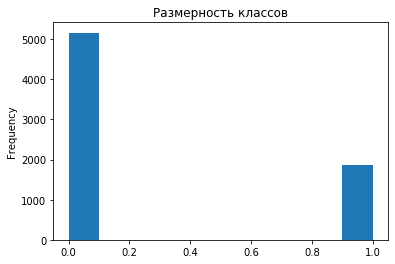

In [58]:
ready_data['ActiveClient'].plot(kind='hist', title='Размерность классов')

Как видно, в данных присутствует дисбаланс, а это значит, что чувствительные модели могут показать результат хуже, чем возможно. Поэтому предлагается осуществить балансировку классов с помощью метода `upsampling`. Для этого создадим специальную функцию, которая принимает в себя два значения: признаки и целевое значение. В функции мы выделяем признаки, где целевое значение равняется 0, а также где равняется 1. Тоже самое осуществляем и с целевыми признаками. После этого формируем новую выборку, где наименьший класс увеличиваем в определенное количество раз. После этого перемешиваем данные и возвращаем выборки:

In [59]:
def upsample(features, target):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_ones] + [features_zeros] * 3)
    target_upsampled = pd.concat([target_ones] + [target_zeros] * 3)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

train_features_upsampled, train_target_upsampled = upsample(train_features, train_target)
print(train_features_upsampled.shape, train_target_upsampled.shape)

(12982, 8) (12982,)


Text(0.5, 1.0, 'Сбалансированная размерность классов')

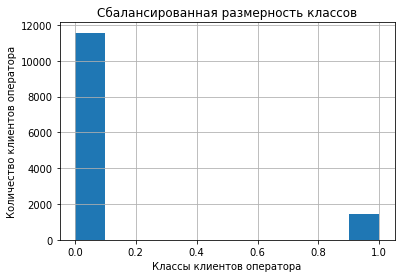

In [60]:
train_target_upsampled.hist()
plt.xlabel('Классы клиентов оператора')
plt.ylabel('Количество клиентов оператора')
plt.title('Сбалансированная размерность классов')

Баланс классов совершен и можно проверить качество моделей без балансировки и с балансировкой.

### Обучение моделей - без параметра upsampling

Для того, чтобы подбирать гиперпараметры было удобно, мы создадим функцию, где и будем просматривать все доступные варианты моделей:

In [61]:
def find_best_param(model, param_grid, features, target):
    model_grid_search = GridSearchCV(
            model, 
            param_grid=param_grid,
            cv=3,
            verbose=4)
    return model_grid_search.fit(features, target)

Первая модель - логистическая регрессия. Возможно именно данная модель покажет результат, сильно скошенный вниз (алгоритм логистической регрессии чувствителен к балансу классов), но надо убедиться в этом. Среди гиперпараметров модели мы будем перебирать:
- обратную силу регуляризации в пределах 0.001 до 100 с шагом *10
- алгоритм оптимизации - liblinear и lbfgs
- веса, где вес класса для клиентов, которые покинули компанию будет выше

Метриками оценки будут f1 и accuracy:

In [ ]:
*

In [64]:
param_grid_linear = {'C':[0.001, 0.01, 0.1, 1, 10, 100], 'solver':['liblinear', 'lbfgs'], 'class_weight':[{0: 1, 1: 1}, {0: 3, 1: 1}, {0: 5, 1: 1}, {0: 1, 1: 0.5}]}
model_linear = LogisticRegression(random_state=12345)
grid_linear = find_best_param(model_linear, param_grid_linear, train_features, train_target)

preds_linear = grid_linear.predict(test_features)

print('LogisticRegression Train accuracy %s' % grid_linear.score(train_features, train_target)) 
print('LogisticRegression Test accuracy %s' % accuracy_score(preds_linear, test_target)) 

print('LogisticRegression f1_score is %s' % f1_score(test_target, preds_linear)) 
print(classification_report(test_target, preds_linear)) 

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] C=0.001, class_weight={0: 1, 1: 1}, solver=liblinear ............
[CV]  C=0.001, class_weight={0: 1, 1: 1}, solver=liblinear, score=0.748, total=   0.0s
[CV] C=0.001, class_weight={0: 1, 1: 1}, solver=liblinear ............
[CV]  C=0.001, class_weight={0: 1, 1: 1}, solver=liblinear, score=0.737, total=   0.0s
[CV] C=0.001, class_weight={0: 1, 1: 1}, solver=liblinear ............
[CV]  C=0.001, class_weight={0: 1, 1: 1}, solver=liblinear, score=0.740, total=   0.1s
[CV] C=0.001, class_weight={0: 1, 1: 1}, solver=lbfgs ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


[CV]  C=0.001, class_weight={0: 1, 1: 1}, solver=lbfgs, score=0.731, total=   0.1s
[CV] C=0.001, class_weight={0: 1, 1: 1}, solver=lbfgs ................
[CV]  C=0.001, class_weight={0: 1, 1: 1}, solver=lbfgs, score=0.731, total=   0.1s
[CV] C=0.001, class_weight={0: 1, 1: 1}, solver=lbfgs ................
[CV]  C=0.001, class_weight={0: 1, 1: 1}, solver=lbfgs, score=0.731, total=   0.1s
[CV] C=0.001, class_weight={0: 3, 1: 1}, solver=liblinear ............
[CV]  C=0.001, class_weight={0: 3, 1: 1}, solver=liblinear, score=0.731, total=   0.1s
[CV] C=0.001, class_weight={0: 3, 1: 1}, solver=liblinear ............
[CV]  C=0.001, class_weight={0: 3, 1: 1}, solver=liblinear, score=0.731, total=   0.2s
[CV] C=0.001, class_weight={0: 3, 1: 1}, solver=liblinear ............
[CV]  C=0.001, class_weight={0: 3, 1: 1}, solver=liblinear, score=0.731, total=   0.1s
[CV] C=0.001, class_weight={0: 3, 1: 1}, solver=lbfgs ................
[CV]  C=0.001, class_weight={0: 3, 1: 1}, solver=lbfgs, score=0.

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:   39.8s finished


LogisticRegression Train accuracy 0.788775123246113
LogisticRegression Test accuracy 0.7952218430034129
LogisticRegression f1_score is 0.569377990430622
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1309
           1       0.61      0.53      0.57       449

    accuracy                           0.80      1758
   macro avg       0.73      0.71      0.72      1758
weighted avg       0.79      0.80      0.79      1758



По алгоритму логистической регрессии можно сказать, что она справилась не очень хорошо с задачей, хотя accucary метрика показала довольно хороший результат: качество по метрике f1 = 0.57, по accuracy = 0.80. 

Теперь давайте проверим случайный лес, у которого гиперпараметрами будут:
- количество деревьев от 50, 100, 200, 300, 500, 1000
- функция измерения качества разделения: gini или entropy
- веса классов, такие же как и логистической регрессии

Метрики такие же:

In [65]:
param_grid_forest = {'n_estimators':[50, 100, 200, 300, 500, 1000], 'criterion':['gini', 'entropy'], 'class_weight':[{0: 1, 1: 1}, {0: 3, 1: 1}, {0: 5, 1: 1}, {0: 1, 1: 0.5}]}
model_forest = RandomForestClassifier(random_state=12345)
grid_forest = find_best_param(model_forest, param_grid_forest, train_features, train_target)

preds_forest = grid_forest.predict(test_features)

print('Forest Train accuracy %s' % grid_forest.score(train_features, train_target)) 
print('Forest Test accuracy %s' % accuracy_score(preds_forest, test_target)) 

print('Forest f1_score is %s' % f1_score(test_target, preds_forest)) 
print(classification_report(test_target, preds_forest)) 

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] class_weight={0: 1, 1: 1}, criterion=gini, n_estimators=50 ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  class_weight={0: 1, 1: 1}, criterion=gini, n_estimators=50, score=0.803, total=   0.3s
[CV] class_weight={0: 1, 1: 1}, criterion=gini, n_estimators=50 ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  class_weight={0: 1, 1: 1}, criterion=gini, n_estimators=50, score=0.783, total=   0.2s
[CV] class_weight={0: 1, 1: 1}, criterion=gini, n_estimators=50 ......


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  class_weight={0: 1, 1: 1}, criterion=gini, n_estimators=50, score=0.803, total=   0.2s
[CV] class_weight={0: 1, 1: 1}, criterion=gini, n_estimators=100 .....


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


[CV]  class_weight={0: 1, 1: 1}, criterion=gini, n_estimators=100, score=0.798, total=   0.5s
[CV] class_weight={0: 1, 1: 1}, criterion=gini, n_estimators=100 .....
[CV]  class_weight={0: 1, 1: 1}, criterion=gini, n_estimators=100, score=0.785, total=   0.5s
[CV] class_weight={0: 1, 1: 1}, criterion=gini, n_estimators=100 .....
[CV]  class_weight={0: 1, 1: 1}, criterion=gini, n_estimators=100, score=0.804, total=   0.5s
[CV] class_weight={0: 1, 1: 1}, criterion=gini, n_estimators=200 .....
[CV]  class_weight={0: 1, 1: 1}, criterion=gini, n_estimators=200, score=0.803, total=   1.3s
[CV] class_weight={0: 1, 1: 1}, criterion=gini, n_estimators=200 .....
[CV]  class_weight={0: 1, 1: 1}, criterion=gini, n_estimators=200, score=0.783, total=   0.9s
[CV] class_weight={0: 1, 1: 1}, criterion=gini, n_estimators=200 .....
[CV]  class_weight={0: 1, 1: 1}, criterion=gini, n_estimators=200, score=0.801, total=   0.9s
[CV] class_weight={0: 1, 1: 1}, criterion=gini, n_estimators=300 .....
[CV]  clas

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  4.4min finished


Forest Train accuracy 0.9981039059537353
Forest Test accuracy 0.800910125142207
Forest f1_score is 0.5783132530120483
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1309
           1       0.63      0.53      0.58       449

    accuracy                           0.80      1758
   macro avg       0.74      0.71      0.72      1758
weighted avg       0.79      0.80      0.80      1758



Алгоритм случайного леса дал нам следующие результаты: f1 = 0.58, accuracy = 0.80. Результат немного лучше, чем у логистической регрессии, но у нас есть еще алгоритм опорных векторов. 

Последний алгоритм, который мы рассмотрим здесь - метод опорных векторов. Среди его гиперпараметров будут:
- обратную силу регуляризации в пределах 0.001 до 100 с шагом *10, также как и у логистической регрессии
- коэффициент ядра от 1 до 0.001 с шагом 0.1
- веса как и у остальных моделей

Метрики опять те же:

In [66]:
param_grid_svc = {'C': [0.001, 0.01,0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001], 'class_weight':[{0: 1, 1: 1}, {0: 3, 1: 1}, {0: 5, 1: 1}, {0: 1, 1: 0.5}]} 
grid_svc = find_best_param(SVC(probability=True), param_grid_svc, train_features, train_target)
preds_svc = grid_svc.predict(test_features)

print('SVM Train accuracy %s' % grid_svc.score(train_features,train_target)) 
print('SVM Test accuracy %s' % accuracy_score(preds_svc, test_target)) 

print('SVM f1_score is %s' % f1_score(test_target, preds_svc)) 
print(classification_report(test_target, preds_svc)) 

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] C=0.001, class_weight={0: 1, 1: 1}, gamma=1 .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.001, class_weight={0: 1, 1: 1}, gamma=1, score=0.731, total=   1.5s
[CV] C=0.001, class_weight={0: 1, 1: 1}, gamma=1 .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV]  C=0.001, class_weight={0: 1, 1: 1}, gamma=1, score=0.731, total=   1.6s
[CV] C=0.001, class_weight={0: 1, 1: 1}, gamma=1 .....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV]  C=0.001, class_weight={0: 1, 1: 1}, gamma=1, score=0.731, total=   1.5s
[CV] C=0.001, class_weight={0: 1, 1: 1}, gamma=0.1 ...................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s


[CV]  C=0.001, class_weight={0: 1, 1: 1}, gamma=0.1, score=0.731, total=   1.6s
[CV] C=0.001, class_weight={0: 1, 1: 1}, gamma=0.1 ...................
[CV]  C=0.001, class_weight={0: 1, 1: 1}, gamma=0.1, score=0.731, total=   1.6s
[CV] C=0.001, class_weight={0: 1, 1: 1}, gamma=0.1 ...................
[CV]  C=0.001, class_weight={0: 1, 1: 1}, gamma=0.1, score=0.731, total=   1.6s
[CV] C=0.001, class_weight={0: 1, 1: 1}, gamma=0.01 ..................
[CV]  C=0.001, class_weight={0: 1, 1: 1}, gamma=0.01, score=0.731, total=   1.5s
[CV] C=0.001, class_weight={0: 1, 1: 1}, gamma=0.01 ..................
[CV]  C=0.001, class_weight={0: 1, 1: 1}, gamma=0.01, score=0.731, total=   1.4s
[CV] C=0.001, class_weight={0: 1, 1: 1}, gamma=0.01 ..................
[CV]  C=0.001, class_weight={0: 1, 1: 1}, gamma=0.01, score=0.731, total=   1.5s
[CV] C=0.001, class_weight={0: 1, 1: 1}, gamma=0.001 .................
[CV]  C=0.001, class_weight={0: 1, 1: 1}, gamma=0.001, score=0.731, total=   1.5s
[CV] C=0.

[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed: 12.8min finished


SVM Train accuracy 0.7999620781190747
SVM Test accuracy 0.8111490329920364
SVM f1_score is 0.5776081424936388
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1309
           1       0.67      0.51      0.58       449

    accuracy                           0.81      1758
   macro avg       0.76      0.71      0.73      1758
weighted avg       0.80      0.81      0.80      1758



Результат алгоритма SVC показал нам лучший результат среди всех использованных моделей. Результаты такие: f1 = 0.58, accuracy = 0.81. Теперь мы можем перейти к обучению моделей с признаками, подготовленными по методу upsampling

### Обучение моделей - с параметром upsampling

С изменением весов классов мы поработали, теперь давайте проверим как покажет себя выборка после upsampling. Начнем с логистической регрессией и ее гиперпараметрами, но уже без параметра весов:

In [67]:
param_grid_linear_upsampled = {'C':[0.01,0.1,1,10, 100], 'solver':['liblinear', 'lbfgs']}
model_linear_upsampled = LogisticRegression(random_state=12345)
grid_linear_upsampled = find_best_param(model_linear_upsampled, param_grid_linear_upsampled, train_features_upsampled, train_target_upsampled)

preds_linear_upsampled = grid_linear_upsampled.predict(test_features)

print('LogisticRegression Train accuracy %s' % grid_linear_upsampled.score(train_features_upsampled, train_target_upsampled)) 
print('LogisticRegression Test accuracy %s' % accuracy_score(preds_linear_upsampled, test_target)) 

print('LogisticRegression f1_score is %s' % f1_score(test_target, preds_linear_upsampled)) 
print(classification_report(test_target, preds_linear_upsampled)) 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=0.01, solver=liblinear ........................................
[CV] ............ C=0.01, solver=liblinear, score=0.890, total=   0.0s
[CV] C=0.01, solver=liblinear ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............ C=0.01, solver=liblinear, score=0.891, total=   0.2s
[CV] C=0.01, solver=liblinear ........................................
[CV] ............ C=0.01, solver=liblinear, score=0.891, total=   0.2s
[CV] C=0.01, solver=lbfgs ............................................

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s



[CV] ................ C=0.01, solver=lbfgs, score=0.890, total=   0.4s
[CV] C=0.01, solver=lbfgs ............................................
[CV] ................ C=0.01, solver=lbfgs, score=0.891, total=   0.5s
[CV] C=0.01, solver=lbfgs ............................................
[CV] ................ C=0.01, solver=lbfgs, score=0.891, total=   0.5s
[CV] C=0.1, solver=liblinear .........................................
[CV] ............. C=0.1, solver=liblinear, score=0.891, total=   0.2s
[CV] C=0.1, solver=liblinear .........................................
[CV] ............. C=0.1, solver=liblinear, score=0.892, total=   0.2s
[CV] C=0.1, solver=liblinear .........................................
[CV] ............. C=0.1, solver=liblinear, score=0.891, total=   0.2s
[CV] C=0.1, solver=lbfgs .............................................
[CV] ................. C=0.1, solver=lbfgs, score=0.891, total=   0.7s
[CV] C=0.1, solver=lbfgs .............................................
[CV] 

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   11.2s finished


LogisticRegression Train accuracy 0.8913110460637806
LogisticRegression Test accuracy 0.7474402730375427
LogisticRegression f1_score is 0.026315789473684213
              precision    recall  f1-score   support

           0       0.75      1.00      0.85      1309
           1       0.86      0.01      0.03       449

    accuracy                           0.75      1758
   macro avg       0.80      0.51      0.44      1758
weighted avg       0.78      0.75      0.64      1758



Результат логистической регрессии после метода upsampling ухудшился и ухудшился сильно, стал равняться f1 = 0.02 и accuracy = 0.75. Картина неприятная, но у нас есть еще две модели, может они покажут результат получше.

Следующий алгоритм - случайный лес с такими же параметрами, кроме весов, конечно же:

In [68]:
param_grid_forest_upsampled = {'n_estimators':[50, 100, 200, 300, 500, 1000], 'criterion':['gini', 'entropy']}
model_forest_upsampled = RandomForestClassifier(random_state=12345)
grid_forest_upsampled = find_best_param(model_forest_upsampled, param_grid_forest_upsampled, train_features_upsampled, train_target_upsampled)

preds_forest_upsampled = grid_forest_upsampled.predict(test_features)

print('Forest Train accuracy %s' % grid_forest_upsampled.score(train_features_upsampled, train_target_upsampled)) 
print('Forest Test accuracy %s' % accuracy_score(preds_forest_upsampled, test_target)) 

print('Forest f1_score is %s' % f1_score(test_target, preds_forest_upsampled)) 
print(classification_report(test_target, preds_forest_upsampled)) 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] criterion=gini, n_estimators=50 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... criterion=gini, n_estimators=50, score=0.930, total=   0.5s
[CV] criterion=gini, n_estimators=50 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ..... criterion=gini, n_estimators=50, score=0.929, total=   0.4s
[CV] criterion=gini, n_estimators=50 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] ..... criterion=gini, n_estimators=50, score=0.930, total=   0.4s
[CV] criterion=gini, n_estimators=100 ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s


[CV] .... criterion=gini, n_estimators=100, score=0.931, total=   0.9s
[CV] criterion=gini, n_estimators=100 ................................
[CV] .... criterion=gini, n_estimators=100, score=0.930, total=   0.9s
[CV] criterion=gini, n_estimators=100 ................................
[CV] .... criterion=gini, n_estimators=100, score=0.929, total=   1.0s
[CV] criterion=gini, n_estimators=200 ................................
[CV] .... criterion=gini, n_estimators=200, score=0.930, total=   1.7s
[CV] criterion=gini, n_estimators=200 ................................
[CV] .... criterion=gini, n_estimators=200, score=0.930, total=   1.7s
[CV] criterion=gini, n_estimators=200 ................................
[CV] .... criterion=gini, n_estimators=200, score=0.929, total=   1.7s
[CV] criterion=gini, n_estimators=300 ................................
[CV] .... criterion=gini, n_estimators=300, score=0.930, total=   2.6s
[CV] criterion=gini, n_estimators=300 ................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.9min finished


Forest Train accuracy 0.9993067323987059
Forest Test accuracy 0.7963594994311718
Forest f1_score is 0.5251989389920424
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1309
           1       0.65      0.44      0.53       449

    accuracy                           0.80      1758
   macro avg       0.74      0.68      0.70      1758
weighted avg       0.78      0.80      0.78      1758



Случайный лес после upsampling показал результат хуже, но не так плохо, как логистическая регрессия: f1 = 0.52 и accuracy = 0.80. В данном алгоритме метод upsampling показал себя также плохо, как и с логистической регрессией.

Последний алгоритм - метод опорных векторов, с аналогичными гиперпараметрами, опять же, без весов:

In [69]:
param_grid_svc_upsampled = {'C': [0.01, 0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]} 
grid_svc_upsampled = find_best_param(SVC(probability=True), param_grid_svc_upsampled, train_features_upsampled, train_target_upsampled)

preds_svc_upsampled = grid_svc_upsampled.predict(test_features)

print('SVM Train accuracy %s' % grid_svc_upsampled.score(train_features_upsampled, train_target_upsampled)) 
print('SVM Test accuracy %s' % accuracy_score(preds_svc_upsampled, test_target)) 

print('SVM f1_score is %s' % f1_score(test_target, preds_svc_upsampled)) 
print(classification_report(test_target, preds_svc_upsampled)) 

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] C=0.01, gamma=1 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... C=0.01, gamma=1, score=0.890, total=   5.4s
[CV] C=0.01, gamma=1 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV] ..................... C=0.01, gamma=1, score=0.891, total=   5.7s
[CV] C=0.01, gamma=1 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s


[CV] ..................... C=0.01, gamma=1, score=0.891, total=   5.4s
[CV] C=0.01, gamma=0.1 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.5s remaining:    0.0s


[CV] ................... C=0.01, gamma=0.1, score=0.890, total=   4.1s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ................... C=0.01, gamma=0.1, score=0.891, total=   4.1s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ................... C=0.01, gamma=0.1, score=0.891, total=   4.0s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .................. C=0.01, gamma=0.01, score=0.890, total=   3.7s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .................. C=0.01, gamma=0.01, score=0.891, total=   3.8s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .................. C=0.01, gamma=0.01, score=0.891, total=   4.2s
[CV] C=0.01, gamma=0.001 .............................................
[CV] ................. C=0.01, gamma=0.001, score=0.890, total=   3.6s
[CV] C=0.01, gamma=0.001 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 12.2min finished


SVM Train accuracy 0.9282853181327992
SVM Test accuracy 0.7502844141069397
SVM f1_score is 0.3894297635605007
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1309
           1       0.52      0.31      0.39       449

    accuracy                           0.75      1758
   macro avg       0.66      0.61      0.62      1758
weighted avg       0.72      0.75      0.73      1758



Результат метода опорных векторов с признаками после метода upsampling равен: f1 = 0.79 и accuracy = 0.73. Результат также как и с остальными получился плохим, но проверить на roc-кривой все же стоит.

## Построение roc-кривой

### Построение roc-кривой - без параметра upsampling

Модели обучены и готовы к построению roc-кривой. Построение кривой будет осуществляться двумя шагами:
- создании функции построения
- использование функции с определенными моделями

`auc_roc` - отображает соотношение между долей объектов от общего количества носителей признака, верно классифицированных и долей объектов от общего количества объектов ошибочно классифицированных при варьировании порога. Для вычисления данной метрики мы воспользуется методом `roc_auc_score`. А для изображения графика воспользуемся методом `roc_curve`:

In [70]:
def create_auc_plot(model, features_auc, target_auc):
    probabilities_valid = model.predict_proba(features_auc)
    probabilities_one_valid = probabilities_valid[:, 1]

    auc_roc = roc_auc_score(target_auc, probabilities_one_valid)

    fpr, tpr, thresholds = roc_curve(target_auc, probabilities_one_valid) 

    plt.figure(figsize=(12,8))
    lw = 2

    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_roc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('Доля ложноположительных ответов')
    plt.ylabel('Доля истинно положительных ответов')

    plt.title('График ROC')
    plt.legend(loc="lower right")

    plt.show()

Как работает построение графика:
- мы высчитываем вероятности ответов нашей модели, которую мы используем в функции. Сохраняем вероятности именно класса 1, так как нам интересен уход клиентов
- высчитываем площадь под кривой методом `roc_auc_score`
- вычисляем долю ложноположительных ответов и долю истинно положительных ответов методом `roc_curve`
- строим два графика: график ROC и график по умолчанию

Первая тройка моделей - без метода upsampling:

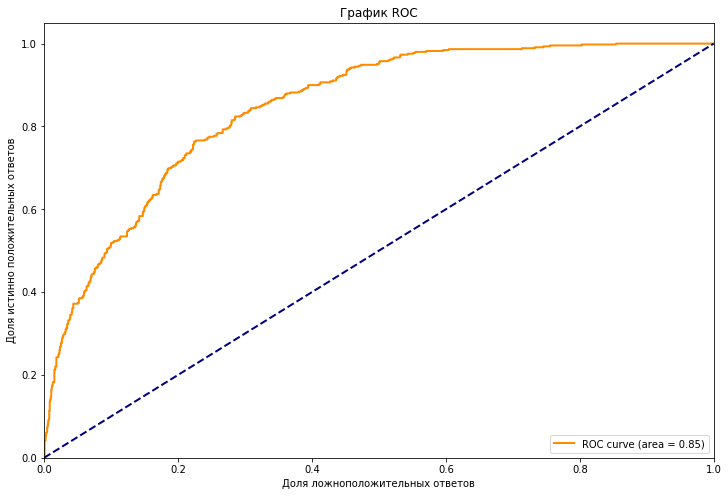

In [71]:
create_auc_plot(grid_linear, test_features, test_target)

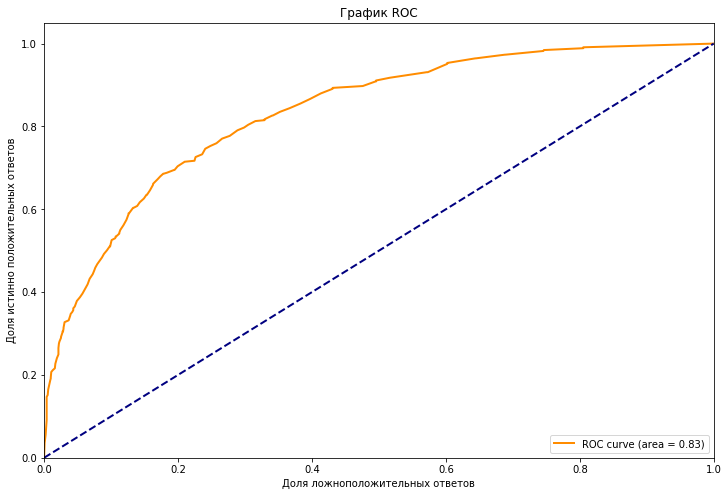

In [72]:
create_auc_plot(grid_forest, test_features, test_target)

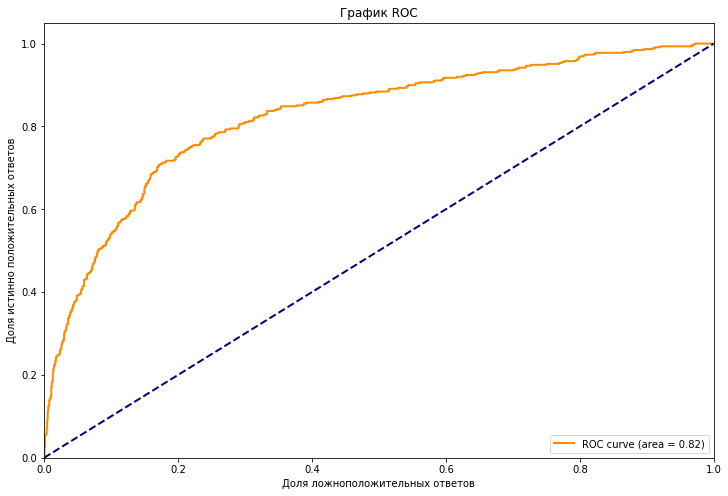

In [73]:
create_auc_plot(grid_svc, test_features, test_target)

Как можно заметить, самый лучший результат получился ну логистической регрессии = 0.84. Показатель не самый лучший, но довольно хороший, однако нужно проверить еще модели с upsampling методом. 

### Построение roc-кривой - с параметром upsampling

Вторая тройка алгоритмов, но уже с upsampling:

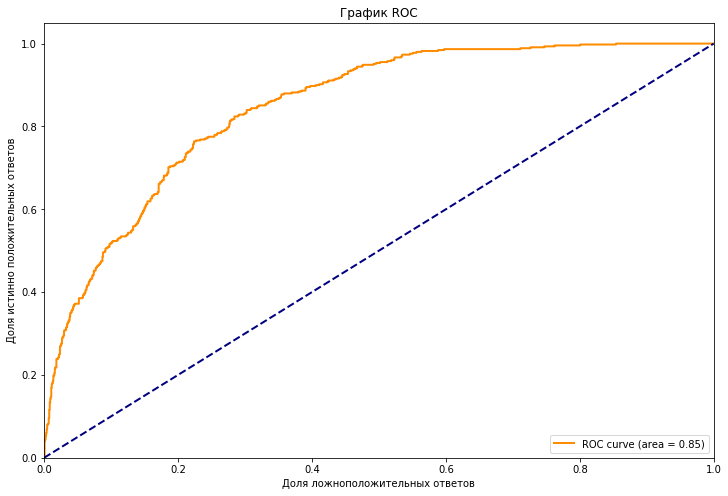

In [74]:
create_auc_plot(grid_linear_upsampled, test_features, test_target)

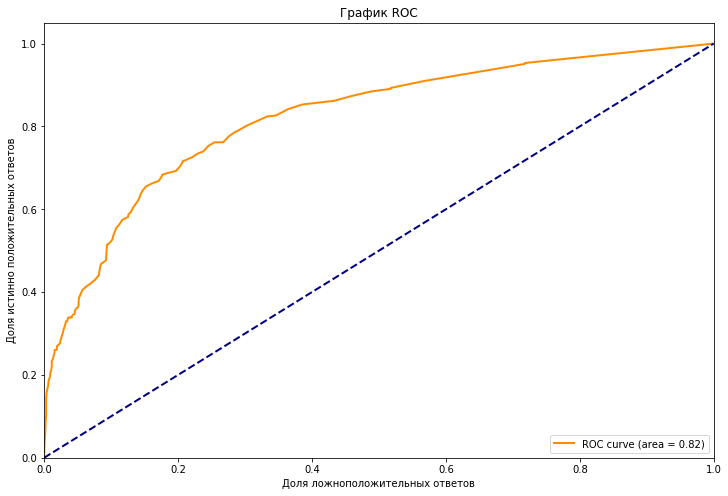

In [75]:
create_auc_plot(grid_forest_upsampled, test_features, test_target)

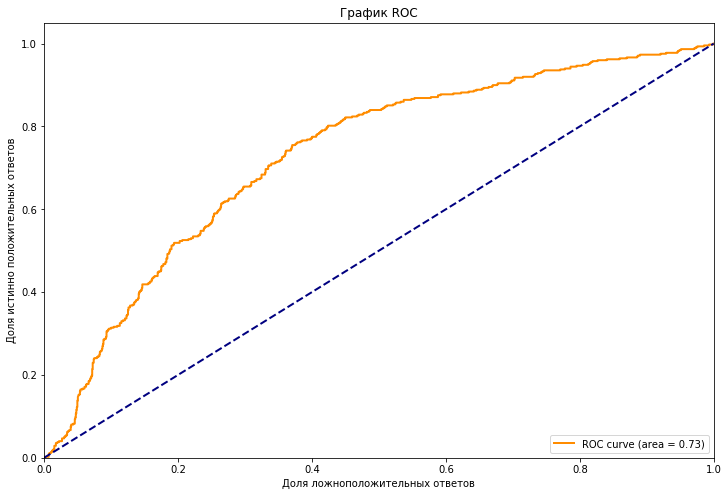

In [76]:
create_auc_plot(grid_svc_upsampled, test_features, test_target)

Результат получился хуже, но лидер имеет такой же результат, как и у алгоритма без upsampling - логистическая регрессия и в этой тройка показала себя прекрасно. 

## Анализ важности факторов

Данный этап необходим для того, чтобы понять, какие факторы необходимы при прогнозе оттока клиентов, а какие не нужны и их можно будет удалить в дальнейшем.

Первая модель, которая покажет нам важность факторов - логистическая:

In [77]:
model_linear = LogisticRegression(C=100, class_weight={0: 1, 1: 1}, solver='lbfgs')
model_linear.fit(train_features,train_target)

LogisticRegression(C=100, class_weight={0: 1, 1: 1}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

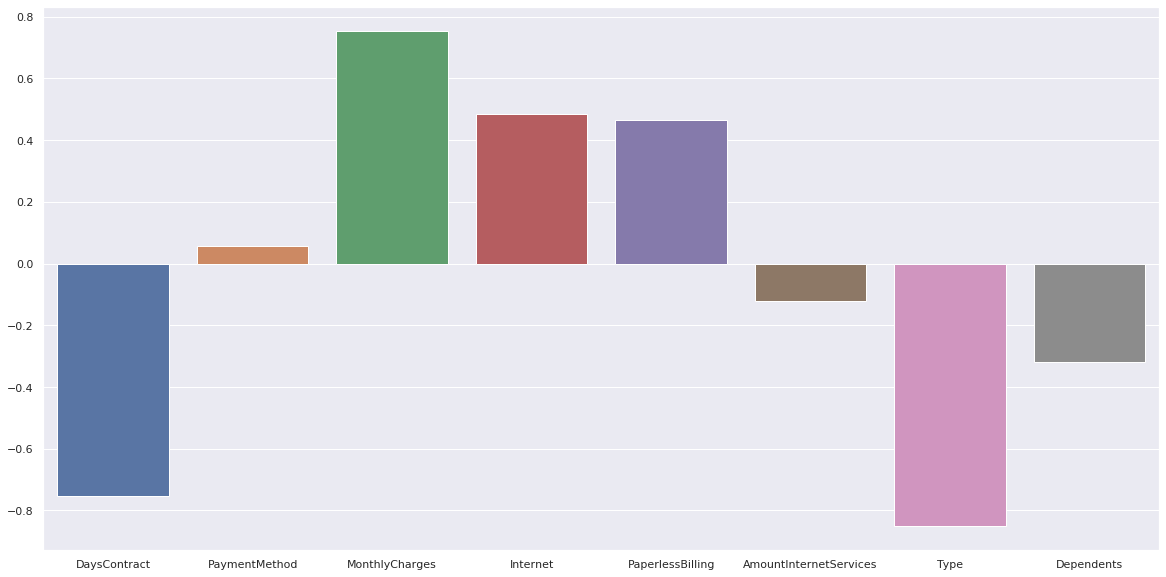

In [82]:
y = model_linear.coef_[0]
x = train_features.columns

sns.set(rc={'figure.figsize':(20,10)})
size = (20,10)
sns.barplot(x=x, y=y)


По логистической модели можно сказать, что у нас есть пять наиболее важных признаков: продолжительность контракта, месячные затраты пользователя, пользуется ли интернетом пользователь, вид оплаты и тип контракта

Далее идет модель случайного леса:

In [79]:
model_forest = RandomForestClassifier(n_estimators=1000, class_weight={0: 1, 1: 1}, criterion='gini')
model_forest.fit(train_features,train_target)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

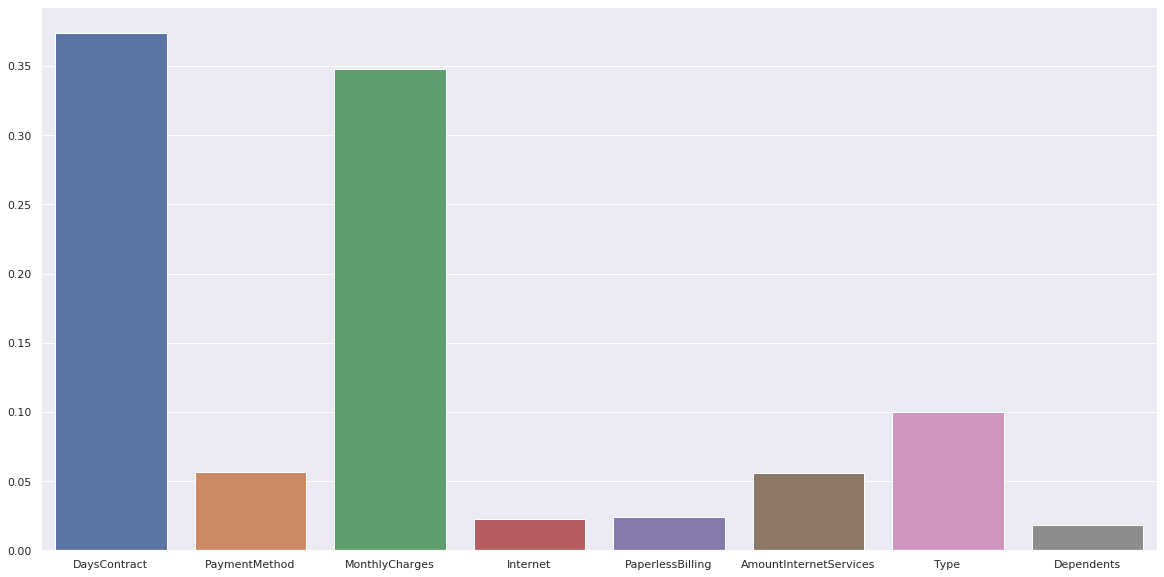

In [80]:
y = model_forest.feature_importances_
x = train_features.columns

size = (20,10)
sns.barplot(x=x, y=y)
sns.set(rc={'figure.figsize':(20,10)})

Модель случайного леса показал очень похожую картину: продолжительность контракта, месячные затраты, тип договора, именно эти признаки наиболее важны при прогнозе оттока клиентов.

## Вывод

В заключении проекта, хотелось бы отметить некоторые выводы и предложения оператору связи:
- после загрузки данных была проведена предобработка данных: удалены некоторые строки, дополнены другие, изменены типы данных, созданы дополнительные столбцы для удобной работы
- все таблицы были объединены в одну целую, откуда были выбраны наиболее подходящие для прогноза оттока клиентов признаки
- проведен исследовательский анализ данных, в процессе которого было выяснено:
    - наиболее прибыльным видом договора является договор на два года, однако в месячном диапазоне лучшим считается договор на месяц;
    - наиболее прибыльным интернет подключением является оптоволокно
    - контракты разрывают чаще всего на 60-100 день, после этого промежутка данный процесс идет на спад
    - 25% всех контрактов, которые разорвали приходится на 61 день, медианой является отметка в 304 день
    - была проведена корреляция и отбор наиболее подходящих признаков для прогноза оттока клиентов
- проведено обучение трех моделей:
    - логистическая регрессия: на выборке без балансировки классов результат auc-roc = 0.84, с балансировкой = 0.84
    - случайный лес: на выборке без балансировки классов результат auc-roc = 0.82, с балансировкой = 0.81
    - метод опорных векторов: на выборке без балансировки классов результат auc-roc = 0.82, с балансировкой = 0.74
- выбрана лучшая модель - логистическая регрессия без балансировки классов. Выбрана за счет лучшего результата на метрике f1, на метрике accuracy и auc-roc. 
- проведен анализ важности признаков на целевую переменную (что больше всего влияет на отток клиентов). Самыми важными признаками оказались: `DaysContract`, `MonthlyCharges` и `Type` (есть еще два признака: `Internet` и `ParelessBilling`, но они были важны только для логистической регрессии, не для случайного леса). Именно на эти признака надо оказывать пристальное внимание.

В качестве предложений оператору связи предлагается разбить сроки пользования услугами на три диапазона:
- до 50 дней. Клиенту, который захочет уйти от оператора в данный промежуток времени, можно предложить дополнительную услугу бесплатно на весь срок пользования услугами оператора
- с 50 до 300 дней. Если пользователь тратит меньше 59 денежных значений и использует от 0-1 дополнительных услуг, то предлагаем бесплатную дополнительную услугу на время пользования услугами оператора.Если пользователь тратит больше 59 денежных значений  и/или использует от 2-4 дополнительных услуг, то предлагаем 25% скидку на месячную оплату всех услуг оператора, бессрочно
- с 300 дней.Если пользователь тратит меньше 70 денежных значений, то ему предлагается скидка 25% либо дополнительная услуга бесплатно в остальных случаях предлагается скидка 50%
